# HAR (human activity recognition) using DNN/DL on fNIRS data

In [1]:
% ls /home/arasdar/datasets/fNIRs-data-10subjects/

P11-4-17-2018/  P13-4-17-2018/  P15-4-18-2018/  P17-4-18-2018/  P19-4-19-2018/
P12-4-17-2018/  P14-4-18-2018/  P16-4-18-2018/  P18-4-19-2018/  P20-4-19-2018/


In [2]:
% ls /home/arasdar/datasets/fNIRs-data-10subjects/P12-4-17-2018/

1. Right Hand/  2. Both Hands/  3. Left Hand/  4. Right Leg/  5. Left Leg/


In [3]:
% ls /home/arasdar/datasets/fNIRs-data-10subjects/P12-4-17-2018/1.\ Right\ Hand

2018-04-17_006/
fNIR_data.txt
head20180417-145130.txt
NIRS-2018-04-17_006_deoxyhb_T141to2511_C1to20.txt
NIRS-2018-04-17_006_oxyhb_T141to2511_C1to20.txt
Processed/
r_hand20180417-145128.txt
r_lower_arm20180417-145129.txt
r_upper_arm20180417-145129.txt


In [4]:
import numpy as np
import os
import pandas as pd

# % find ../../datasets/fNIRs_data/ | grep fNIR_data # NOT WORKING!!
def find_all(name, path):
    result = []
    for root, dirs, files in os.walk(path):
        if name in files:
            result.append(os.path.join(root, name))
    return result

allpaths = find_all(name='fNIR_data.txt', path='/home/arasdar/datasets/fNIRs-data-10subjects/')
allpaths = sorted(allpaths, reverse=False)
# print(allpaths, len(allpaths))
# allpaths, len(allpaths)

In [5]:
# df: data frame object
df = []
for each_idx in range(len(allpaths)):
    file = pd.read_csv(filepath_or_buffer=allpaths[each_idx], names=['time', 'sample', 
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel'],
                         header=None)
    df.append(file)
    
for each in range(len(df)):
#     print(df[each].shape, allpaths[each])
    df[each]=df[each].drop(axis=1, columns=None, index=None, labels=['time', 'sample'])
    df[each] = df[each].dropna()
    df[each]['channel.39'] = df[each]['channel.39'].astype(str).str[1:-1].astype(float)
# print(len(df))

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/pandas/io/parsers.py:678: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


In [6]:
data, labels = [], []
for each in range(0, len(df), 1):
    dfmat = df[each].as_matrix()
    label = allpaths[each][59:60]
#     print(dfmat.dtype, dfmat.shape, label, allpaths[each])
    data.append(dfmat)
    labels.append(label)
len(data), len(labels)

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(48, 48)

In [7]:
# This is very much like a convolution for extracting the windows
# size/width, stride/overlap, padding, dilation, num filters/out channel
def minibatching(X, Y, stride, width):
    Xmb, Ymb = [], []
    print(len(X), len(Y))
    # 1st and 1st
    for eachX in range(len(X)):
        num_mb = ((X[eachX].shape[0]-width)//stride)+1
        for each in range(num_mb):
            # The max is (num_mb-1)*stride+width==X[idx].shape[0]
            # The last each is (num_mb-1)
            # each = ((each-1)*stride)+width
            each *= stride
            Xmb.append(X[eachX][each:each+width])
            # There is only one label for one image signal or signal window or temporal window
            #Ymb.append(Y[eachX][each:each+1])
            Ymb.append(Y[eachX])
    return Xmb, Ymb

In [8]:
# Width is based on the sampling rate which is roughly about 233 points per window
# for 10sec rest and 20 sec activity
width = 250
Xmb, Ymb = minibatching(X=data, Y=labels, stride=1, width=width)
# for eachX, eachY in zip(Xmb, Ymb):
#     print(eachX.shape, eachY)
print(len(Xmb), len(Ymb))
print(Xmb[0].shape, Xmb[0].dtype)
print(Ymb[0])

48 48
69615 69615
(250, 40) float64
1


In [9]:
# Conversion from python list to numpy array
X, Y=np.array(object=Xmb, dtype=float), np.array(object=Ymb, dtype=int)
print(X.shape, X.dtype, Y.shape, Y.dtype)

(69615, 250, 40) float64 (69615,) int64


In [10]:
# Now I should devide the data into train and test
# Train and valid split
from sklearn.model_selection import train_test_split

# 30% of the training data/ entire training data is assigned to validation.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.30)
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)
print(Xtrain.dtype, Xtest.dtype, Ytrain.dtype, Ytest.dtype)

(48730, 250, 40) (20885, 250, 40) (48730,) (20885,)
float64 float64 int64 int64


In [11]:
# # # standardizing/normalizing the train and test data
# # def standardize(train, test):
# # """ Standardize data """
# # # Standardize train and test
# # X_train = (train - np.mean(train, axis=0)[None,:,:]) / np.std(train, axis=0)[None,:,:]
# # X_test = (test - np.mean(test, axis=0)[None,:,:]) / np.std(test, axis=0)[None,:,:]
# # return X_train, X_test

# Xtrain = (Xtrain - Xtrain.mean(axis=0))/ Xtrain.std(axis=0)
# Xtest = (Xtest - Xtest.mean(axis=0))/ Xtest.std(axis=0)
# print(Xtrain.shape, Xtrain.dtype)
# print(Xtest.shape, Xtest.dtype)

In [12]:
print(Xtrain.mean(axis=0), Xtrain.std(axis=0))

[[0.23637019 0.20642145 0.18419498 ... 0.45873557 0.52787807 0.4957739 ]
 [0.2363584  0.20646367 0.18421331 ... 0.45872574 0.52779556 0.49575172]
 [0.23634598 0.20642679 0.18419851 ... 0.45878265 0.52781077 0.49579496]
 ...
 [0.23630736 0.20695692 0.18464566 ... 0.45977822 0.52907406 0.49861718]
 [0.23630134 0.20696392 0.18466867 ... 0.4597917  0.52903336 0.49861989]
 [0.23630062 0.20695497 0.18468713 ... 0.45972615 0.52906069 0.49861694]] [[0.19326227 0.16663829 0.22138985 ... 0.42345836 0.3297871  0.39493205]
 [0.19327974 0.1666823  0.22137178 ... 0.42346723 0.32972463 0.39490558]
 [0.19327901 0.16664062 0.22140734 ... 0.42352828 0.32968669 0.3949526 ]
 ...
 [0.19391031 0.16672848 0.22204604 ... 0.42310837 0.33131405 0.39838111]
 [0.19391192 0.1667266  0.22206008 ... 0.4231748  0.33129012 0.39839947]
 [0.19392901 0.16675071 0.22208091 ... 0.42313274 0.33135771 0.39840696]]


In [13]:
print(Xtest.mean(axis=0), Xtest.std(axis=0))

[[0.23572871 0.20442383 0.18514302 ... 0.46209134 0.52799438 0.49424844]
 [0.23575493 0.2043311  0.18510949 ... 0.46212982 0.52819059 0.49433338]
 [0.23578111 0.20442437 0.18515266 ... 0.46201408 0.52815248 0.49426973]
 ...
 [0.23571174 0.20497905 0.18568351 ... 0.46274734 0.52922574 0.49690166]
 [0.23572781 0.20496787 0.18563977 ... 0.46272001 0.52933713 0.49690032]
 [0.23573704 0.20499663 0.18560206 ... 0.46288294 0.52928229 0.49691164]] [[0.19235662 0.16583512 0.2223243  ... 0.42505091 0.32806638 0.39306703]
 [0.19232157 0.16572109 0.22237675 ... 0.42503557 0.3282151  0.39319328]
 [0.1923251  0.16581456 0.22230253 ... 0.42489153 0.32829699 0.39314936]
 ...
 [0.19308018 0.16608327 0.22307133 ... 0.42412843 0.32983952 0.39636917]
 [0.19307548 0.16609224 0.22303748 ... 0.42397507 0.32992723 0.39633696]
 [0.19304368 0.16604746 0.22299884 ... 0.42407569 0.32979748 0.39633043]]


In [14]:
# Now separating train and validation set
# 30% of the training data/ entire training data is assigned to validation.
Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(Xtrain, Ytrain, test_size=0.30)
print(Xtrain.shape, Xvalid.shape, Xtest.shape, Xtrain.dtype, Xvalid.dtype, Xtest.dtype)
print(Ytrain.shape, Yvalid.shape, Ytest.shape, Ytrain.dtype, Yvalid.dtype, Ytest.dtype)

(34111, 250, 40) (14619, 250, 40) (20885, 250, 40) float64 float64 float64
(34111,) (14619,) (20885,) int64 int64 int64


In [15]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


In [17]:
def model_input(input_size, output_size):
    #     N, W, Cin = Xvalid.shape[0], Xvalid.shape[1], Xvalid.shape[2]
    Xinputs = tf.placeholder(dtype=tf.float32, shape=[None, *input_size], name='Xinputs')
    
    #     N, Cout = Yvalid.shape[0], Yvalid.shape[1]
    Yindices = tf.placeholder(dtype=tf.int32, shape=[None], name='Yindices')
    
    # # Batchnorm mode: training and inference/testing/validation
    # #is_bn_training = tf.placeholder(dtype=tf.bool, shape=[], name='is_bn_training')
    # training = tf.placeholder(dtype=tf.bool, shape=[], name='training')

    # returning input data/sequences, output labels/classes
    return Xinputs, Yindices

In [18]:
# Discriminator/ classifier/ recognizer
def discriminator(Xinputs, input_size, output_size, hidden_size, training=True, reuse=False, alpha=0.1):
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Flatten/Vectorize the input data tensor for FC/fully connected layer/Dense Layer
        Xinputs_vec = tf.reshape(tensor=Xinputs, shape=[-1, input_size[0]*input_size[1]])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=Xinputs_vec, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=output_size)   
        #predictions = tf.nn.softmax(logits)
        
        # return output logits for loss and accuracy
        return logits

In [19]:
# # Discriminator/ classifier/ recognizer
# def discriminator(Xinputs, input_size, output_size, hidden_size, reuse=False, alpha=0.1, training=True):
#     with tf.variable_scope('discriminator', reuse=reuse):
        
#         # Flatten/Vectorize the input data tensor for FC/fully connected layer/Dense Layer
#         Xinputs_vec = tf.reshape(tensor=Xinputs, shape=[-1, input_size[0]*input_size[1]])
        
#         # First fully connected layer
#         h1 = tf.layers.dense(inputs=Xinputs_vec, units=hidden_size)
#         nl1 = tf.maximum(alpha * h1, h1)
        
#         # Second fully connected layer
#         h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
#         nl2 = tf.maximum(alpha * h2, h2)
        
#         # Output layer
#         logits = tf.layers.dense(inputs=nl2, units=output_size)   
#         #predictions = tf.nn.softmax(logits)
        
#         # return output logits for loss and accuracy
#         return logits

In [20]:
# This is the forward propagation of the model to calculate the loss.
def model_loss(Xinputs, Yindices, input_size, output_size, hidden_size):
    Ylogits = discriminator(Xinputs=Xinputs, input_size=input_size, output_size=output_size, 
                            hidden_size=hidden_size)
    Ylabels = tf.one_hot(indices=Yindices, depth=output_size, dtype=Ylogits.dtype)
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Ylogits, labels=Ylabels))
    
    acc_tensor = tf.equal(x=tf.argmax(axis=1, input=Ylogits), y=tf.argmax(axis=1, input=Ylabels))
    acc = tf.reduce_mean(axis=0, input_tensor=tf.cast(dtype=tf.float32, x=acc_tensor))

    return loss, acc

In [21]:
# def model_opt(loss, learning_rate):
#     """
#     Get optimization operations in order
#     :param loss: Discriminator/classifier loss Tensor
#     :param learning_rate: Learning Rate Placeholder
#     :return: A tuple of (discriminator training)
#     """
#     # Get weights and bias to update
#     t_vars = tf.trainable_variables()
#     # q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at
#     # g_vars = [var for var in t_vars if var.name.startswith('generator')] # G: next state St/st
#     # d_vars = [var for var in t_vars if var.name.startswith('discriminator')] # D: reward Rt/rt
#     var_list = [var for var in t_vars if var.name.startswith('discriminator')] # D: reward Rt/rt
    
#     # Optimize
#     with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
#         # q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)
#         # g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
#         # d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
#         opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=var_list)

#     return opt

In [22]:
class MLP:
    def __init__(self, input_size, output_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.Xinputs, self.Yindices = model_input(input_size=input_size, output_size=output_size)

        # Create the Model: calculating the loss and forwad pass
        self.loss, self.acc = model_loss(Xinputs=self.Xinputs, Yindices=self.Yindices,
                                         input_size=input_size, output_size=output_size, hidden_size=hidden_size)

        # Update the model: backward pass and backprop
        #self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)
        self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

In [23]:
def get_batches(X, Y, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, Y = X[:n_batches*batch_size], Y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], Y[b:b+batch_size]

In [24]:
# Network Hyper-parameters

# # Input
# Xwidth, Xchannels = Xvalid.shape[1], Xvalid.shape[2]

# Output layer
assert Ytrain.max()==Ytest.max()==Yvalid.max(), 'Output classes'
# Ychannels = Yvalid.max()

# Hidden layer
input_size = [Xvalid.shape[1], Xvalid.shape[2]]
hidden_size = Xvalid.shape[1]* Xvalid.shape[2]
output_size = Yvalid.max()

# learning parameters
batch_size = Xvalid.shape[0]//1 # experience mini-batch size
train_epochs = 100               # max number of training episodes/epochs
learning_rate = 0.001            # learning rate for training/optimization/adam

In [25]:
print('Yvalid.max(), Yvalid.min():', Yvalid.max(), Yvalid.min())
print('Yvalid.shape:', Yvalid.shape)
print('Xvalid.shape:', Xvalid.shape)

Yvalid.max(), Yvalid.min(): 5 1
Yvalid.shape: (14619,)
Xvalid.shape: (14619, 250, 40)


In [26]:
tf.reset_default_graph()

model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size, learning_rate=learning_rate)

In [27]:
# We should save the after training and validation
saver = tf.train.Saver() 

# Loss and accuracy of the model for training and validation
train_loss_mean, valid_loss_mean = [], []
train_acc_mean, valid_acc_mean = [], []

# now that we can calculate loss and optimize, we can start a session for calculating the error.
with tf.Session() as sess:
    
    # Initialize all the model parameters/variables
    sess.run(fetches=tf.global_variables_initializer())
    
    #     # Restoring/loading/uploading the trained and validated model
    #     saver.restore(sess,'checkpoints/mlp-fnirs-har.ckpt')
    
    # for every epoch start feeding the arrays into the tensors in the model
    for epoch in range(train_epochs):
        train_loss, valid_loss = [], []
        train_acc, valid_acc = [], []
        
        # Training
        for Xinputs, Yindices in get_batches(X=Xtrain, Y=Ytrain, batch_size=batch_size):
            feed_dict = {model.Xinputs: Xinputs, model.Yindices: Yindices}
            loss, acc, _ = sess.run(fetches=[model.loss, model.acc, model.opt], feed_dict=feed_dict)
            train_loss.append(loss)
            train_acc.append(acc)
            
        # printing out train and validation loss
        print('epoch:', epoch+1, 'train_loss:', np.mean(train_loss), 'train_acc:', np.mean(train_acc))
        
        # Validation
        for Xinputs, Yindices in get_batches(X=Xvalid, Y=Yvalid, batch_size=batch_size):
            feed_dict = {model.Xinputs: Xinputs, model.Yindices: Yindices}
            loss, acc = sess.run(fetches=[model.loss, model.acc], feed_dict=feed_dict)
            valid_loss.append(loss)
            valid_acc.append(acc)
        
        # printing out train and validation loss
        print('epoch:', epoch+1, 'valid_loss:', np.mean(valid_loss), 'valid_acc:', np.mean(valid_acc))

        #         # printing out train and validation loss
        #         print('epoch:', epoch+1, 
        #               'train_loss:', np.mean(train_loss), 'valid_loss:', np.mean(valid_loss),
        #               'train_acc:', np.mean(train_acc), 'valid_acc:', np.mean(valid_acc))
        
        # Saving the losses for plotting
        train_loss_mean.append(np.mean(train_loss))
        train_acc_mean.append(np.mean(train_acc))
        valid_loss_mean.append(np.mean(valid_loss))
        valid_acc_mean.append(np.mean(valid_acc))
    
    # Saving the trained and validated model
    saver.save(sess,'checkpoints/mlp-fnirs-har.ckpt')

epoch: 1 train_loss: 7.794896 train_acc: 0.17778233
epoch: 1 valid_loss: 11.201307 valid_acc: 0.30761337
epoch: 2 train_loss: 9.761724 train_acc: 0.31558245
epoch: 2 valid_loss: 6.365577 valid_acc: 0.4104932
epoch: 3 train_loss: 6.025879 train_acc: 0.4071756
epoch: 3 valid_loss: 4.861468 valid_acc: 0.37895888
epoch: 4 train_loss: 4.741349 train_acc: 0.37393117
epoch: 4 valid_loss: 3.9105365 valid_acc: 0.39031398
epoch: 5 train_loss: 3.4440317 train_acc: 0.41924894
epoch: 5 valid_loss: 2.5670578 valid_acc: 0.47096244
epoch: 6 train_loss: 2.4985185 train_acc: 0.46265134
epoch: 6 valid_loss: 2.0360177 valid_acc: 0.46795267
epoch: 7 train_loss: 1.9383054 train_acc: 0.47465628
epoch: 7 valid_loss: 1.778005 valid_acc: 0.47718722
epoch: 8 train_loss: 1.7659402 train_acc: 0.47923934
epoch: 8 valid_loss: 1.4144932 valid_acc: 0.5028388
epoch: 9 train_loss: 1.2716937 train_acc: 0.526062
epoch: 9 valid_loss: 1.1188365 valid_acc: 0.55106366
epoch: 10 train_loss: 1.1424346 train_acc: 0.5182297
epoch

epoch: 77 valid_loss: 1.0183585 valid_acc: 0.59142214
epoch: 78 train_loss: 0.9704224 train_acc: 0.6042137
epoch: 78 valid_loss: 0.9735984 valid_acc: 0.5813667
epoch: 79 train_loss: 0.8746164 train_acc: 0.61734724
epoch: 79 valid_loss: 1.0577918 valid_acc: 0.5581093
epoch: 80 train_loss: 0.90153766 train_acc: 0.6211095
epoch: 80 valid_loss: 0.5556211 valid_acc: 0.7419796
epoch: 81 train_loss: 0.7468107 train_acc: 0.725973
epoch: 81 valid_loss: 0.9602521 valid_acc: 0.70606744
epoch: 82 train_loss: 0.72458863 train_acc: 0.69970584
epoch: 82 valid_loss: 0.68995845 valid_acc: 0.68308365
epoch: 83 train_loss: 0.6807029 train_acc: 0.66605103
epoch: 83 valid_loss: 1.1144801 valid_acc: 0.6474451
epoch: 84 train_loss: 0.79855305 train_acc: 0.67973185
epoch: 84 valid_loss: 0.6380516 valid_acc: 0.63273823
epoch: 85 train_loss: 0.7076428 train_acc: 0.6451536
epoch: 85 valid_loss: 0.42717505 valid_acc: 0.71673846
epoch: 86 train_loss: 0.46174538 train_acc: 0.7658185
epoch: 86 valid_loss: 0.73784983

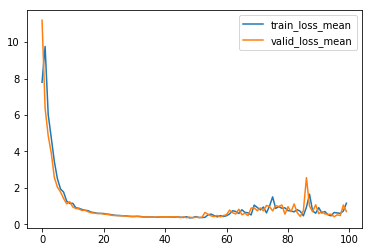

In [28]:
import matplotlib.pyplot as mplot
%matplotlib inline

mplot.plot(train_loss_mean, label='train_loss_mean')
mplot.plot(valid_loss_mean, label='valid_loss_mean')
mplot.legend()

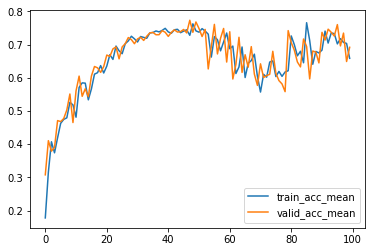

In [29]:
mplot.plot(train_acc_mean, label='train_acc_mean')
mplot.plot(valid_acc_mean, label='valid_acc_mean')
mplot.legend()

In [30]:
with tf.Session() as sess:
    sess.run(fetches=tf.global_variables_initializer())
    
    # Restoring/loading/uploading the trained and validated model
    saver.restore(sess,'checkpoints/mlp-fnirs-har.ckpt')
    
    # Saving the test loss for every batch/minibtch
    test_loss, test_acc = [], []
    
    # Testing
    for Xinputs, Yindices in get_batches(X=Xtest, Y=Ytest, batch_size=batch_size):
        feed_dict = {model.Xinputs: Xinputs, model.Yindices: Yindices}
        loss, acc = sess.run(fetches=[model.loss, model.acc], feed_dict=feed_dict)
        test_loss.append(loss)
        test_acc.append(acc)
        
    # Printing the test loss
    print('test_loss:', np.mean(test_loss), 'test acc', np.mean(test_acc))

INFO:tensorflow:Restoring parameters from checkpoints/mlp-fnirs-har.ckpt
test_loss: 0.72192466 test acc 0.68486214


In [ ]:
# test_loss: 0.7203058 test acc 0.67275465